In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular
from scipy.linalg import lu
import pandas as pd

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [2]:
def finDif(omega,f,n,bc):
    h = (omega[1] - omega[0]) / (n-1)
    
    # Part for solving the matrix = A
    coeff_1 = 1*np.ones((n-2,))
    coeff_2 = -16*np.ones((n-1,))
    coeff_3 = 30*np.ones((n,))
    
    #A = np.zeros((n,n))
    
    A = (np.diag(coeff_1, -2) + np.diag(coeff_2, -1) + np.diag(coeff_3, 0)
        + np.diag(coeff_2, +1) + np.diag(coeff_1, +2))
    
    A = A/(12.*(h**2))
    
    # Part for solving the RHS = b
    x = np.linspace(omega[0], omega[1], n)
    b = f(x)
    
    # Boundary conditions
    A[0,:] = 0
    A[:,0] = 0
    A[-1,:] = 0
    A[:,-1] = 0
    A[0,0] = A[-1,-1] = 1
    b[0] = bc[0]/(h**2)
    b[-1] = bc[1]/(h**2)
    
    return A, b

Call the function using:

In [3]:
omega = [0,np.pi]
f = lambda x : np.sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

#print(A)
#print(b)

# Solve the linear system using numpy
xx = np.linspace(omega[0], omega[1], n)
#fx = np.sin(xx)
#A1 = A.copy()
#u = np.linalg.solve(A1, fx)
u_numpy = np.linalg.solve(A, b)
u_ex = np.sin(xx)

# Plot the FD and exact solution
#_ = plt.plot(xx,u,'ro',label='estimated solution')
#_ = plt.plot(xx,u_ex,'go',label='exact solution')
#plt.legend()

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [4]:
def LU(A):
    A = A.copy()
    N=len(A)
    
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
            
        A[k+1:N,k] /= A[k,k]
        
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    L=np.tril(A)
    
    for i in range(N):
        L[i,i]=1.0
        
    U = np.triu(A)
    return L, U

L, U = LU(A)

In [5]:
def cholesky(A):
    A = A.copy()
    N = len(A)
    
    for k in range(N-1):
        A[k,k] = np.sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = np.sqrt(A[-1,-1])
    L=np.tril(A)
    return L, L.transpose()

HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [6]:
def L_solve(L,rhs):
    x = np.zeros_like(rhs)
    N = len(L)
        
    x[0] = rhs[0]/L[0,0]
    
    for i in range(1,N):
        x[i] = (rhs[i] - np.dot(L[i, 0:i], x[0:i]))/L[i,i]
        
    return x

In [7]:
def U_solve(U,rhs):
    x = np.zeros_like(rhs)
    N = len(U)
    
    x[-1] = rhs[-1]/L[-1,-1]
    
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] - np.dot(U[i, i+1:N], x[i+1:N]))/U[i,i]

    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

Maximum error (numpy): 6.294964549624638e-14
Maximum error (analytical): 0.0024541617562829354


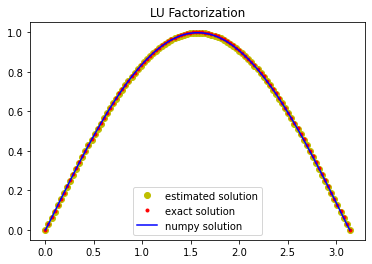

In [8]:
xx = np.linspace(omega[0], omega[1], n)

w = L_solve(L,b)
u = U_solve(U,w)

plt.title("LU Factorization")
_ = plt.plot(xx,u,'yo',label='estimated solution')
_ = plt.plot(xx,u_ex, 'r.',label='exact solution')
_ = plt.plot(xx,u_numpy, 'b',label='numpy solution')
plt.legend()

print("Maximum error (numpy):", max(abs(u-u_numpy)))
print("Maximum error (analytical):", max(abs(u-u_ex)))

Maximum error (numpy): 2.5646151868841116e-14
Maximum error (analytical): 0.0024541617562779117


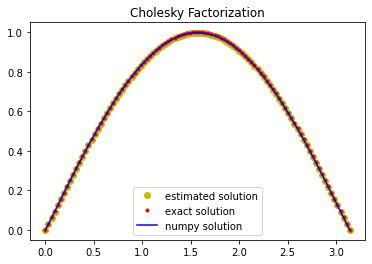

In [9]:
xx = np.linspace(omega[0], omega[1], n)

w = L_solve(HT,b)
u = U_solve(H,w)

plt.title("Cholesky Factorization")
_ = plt.plot(xx,u,'yo',label='estimated solution')
_ = plt.plot(xx,u_ex, 'r.',label='exact solution')
_ = plt.plot(xx,u_numpy, 'b',label='numpy solution')
plt.legend()

print("Maximum error (numpy):", max(abs(u-u_numpy)))
print("Maximum error (analytical):", max(abs(u-u_ex)))

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [10]:
def error_analysis(f,bc,omega,n_range,f_exact):
    error=[]
    for i in n_range:
        x_vals = np.linspace(omega[0], omega[1], i)
        #u_ex = x_vals**4/12. - x_vals**3/6. + x_vals/12.
        u_ex = f_exact(x_vals)
        A_i, b_i = finDif(omega, f, i, bc)
        
        L_i, U_i = LU(A_i)
        w_i = L_solve(L_i, b_i)
        u_i = U_solve(U_i, w_i)
        
        error.append(np.linalg.norm(np.abs(u_ex - u_i), 2))
        
    return error

,n,error
0,10,0.001936
1,20,0.001419
2,30,0.001167
3,40,0.001013
4,50,0.000908
5,60,0.000829
6,70,0.000768
7,80,0.000719
8,90,0.000678
9,100,0.000643


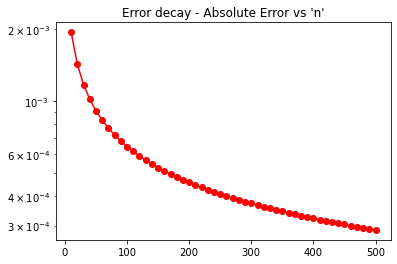

In [11]:
omega_new = [0,1]
f_new = lambda x : x*(1-x)
bc_new = [0,0]

n_range = np.arange(10,501,10)
f_exact = lambda x : (pow(x,4)/12 - pow(x,3)/6 + x/12)

errors = error_analysis(f_new, bc_new, omega_new, n_range,f_exact)

df = pd.DataFrame({'n' : n_range, 'error' : errors})  
display(df)

plt.title("Error decay - Absolute Error vs 'n'")
_ = plt.semilogy(n_range, errors, 'ro-')

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [12]:
# Power Method Function - needed for Condition Number Solution
def PM(A,z0,tol,nmax):
    q = z0/np.linalg.norm(z0,2)
    it = 0
    err = tol + 1.
    
    while it < nmax and err > tol:
        z = np.dot(A,q)
        l = np.dot(q.T,z)
        err = np.linalg.norm(z-l*q,2)
        q = z/np.linalg.norm(z,2)
        it += 1
    
    return l,q

In [13]:
# Inverse Power Method Function - needed for Condition Number Solution
def IPM(A,x0,mu,tol,nmax):
    I = np.eye(len(A))
    M = A - mu*I
    L,U = LU(M)
    q = x0/np.linalg.norm(x0,2)
    err = tol + 1.0
    it = 0
    
    while it < nmax and err > tol:
        y = L_solve(L,q)
        x = U_solve(U,y)
        q = x/np.linalg.norm(x,2)
        z = np.dot(A,q)
        l = np.dot(q.T,z)
        err = np.linalg.norm(z-l*q,2)
        it += 1
        
    #I = np.eye(len(A))
    #M = A - mu*I
    #P,L,U = lu(M) #scipy's LU factorization
    #err = tol + 1.
    #it = 0
    #q = x0/np.linalg.norm(x0,2)
    
    #while it < nmax and err > tol:
    #    y = solve_triangular(L, np.dot(P.T,q), lower=True)
    #    x = solve_triangular(U, y)
    #    q = x/np.linalg.norm(x,2)
    #    z = np.dot(A,q)
    #    l = np.dot(q.T,z)
    #    err = np.linalg.norm(z-l*q,2)
    #    it += 1
    
    return l,q   

In [14]:
def condNumb(A):
    z0 = np.random.rand(A.shape[0])
    mu = 0.0
    tol = 1e-7
    nmax = 13000
    lmax = PM(A,z0,tol,nmax)[0]
    lmin = IPM(A,z0,mu,tol,nmax)[0]
    condNu = lmax/lmin
    
    return condNu

print("Condition Number we calculate:", condNumb(A))
print("Condition Number from Numpy:", np.linalg.cond(A))

Condition Number we calculate: 5294.598016123485
Condition Number from Numpy: 5294.598016140671


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [15]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-11):
    N = len(A)
    x = np.zeros_like(b)
    r = b - np.dot(A,x)
    rho_old = 1.
    p_old = np.zeros_like(b)
    tol = eps + 1.0
    it = 0
    
    while (it < nmax and tol > eps):
        it += 1
        z = np.linalg.solve(P,r)
        rho = np.dot(r,z)
        if (it > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        
        q = np.dot(A,p)
        alpha = rho/np.dot(p,q)
        
        x += p*alpha
        r -= q*alpha
        p_old = p
        rho_old = rho
        tol = np.linalg.norm(r,2)

    #print(it,tol)

    return x

Maximum error (numpy): 2.5646151868841116e-14
Maximum error (analytical): 0.0024541617562779117


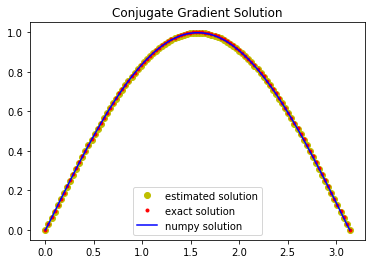

In [16]:
# Verifying Conjugate Gradient solution
xx = np.linspace(omega[0], omega[1], n)
u_ex = np.sin(xx)
u_cg = conjugate_gradient(A, b, np.diag(np.diag(A)))

plt.title("Conjugate Gradient Solution")
_ = plt.plot(xx,u_cg,'yo',label='estimated solution')
_ = plt.plot(xx,u_ex, 'r.',label='exact solution')
_ = plt.plot(xx,u_numpy, 'b',label='numpy solution')
plt.legend()

print("Maximum error (numpy):", max(abs(u-u_numpy)))
print("Maximum error (analytical):", max(abs(u-u_ex)))

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [17]:
# Forward Euler Method Function
def fe(A,b,l,y0,t0,tf,h):
    timesteps = np.arange(t0,tf+1e-10,h)
    t = timesteps
    sol = np.zeros((len(t), len(y0)))
    sol[0,:] = y0
    
    for i in range(1,len(t)):
        u_xx = -np.dot(A,sol[i-1])     
        l_b = np.dot(l(t[i-1]),b)       
        sol[i] = sol[i-1] + h*u_xx + h*l_b
    
    return sol, timesteps

In [18]:
t0 = 0
tf = 6*np.pi
alpha = lambda x: np.cos(x)

omega = [0,np.pi] # reusing original omega
n=100 # reusing original n

# inv of max eigenvalue is taken as a step
tol = 1e-7
nmax = 13000
xx = np.linspace(omega[0], omega[1], n)
eigenvalue_max,_ = PM(A,np.ones_like(xx),tol,nmax) 
h = 1/(eigenvalue_max)

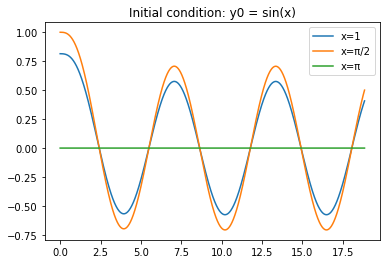

In [19]:
# Initial condition: y0 = sin(x)
y0 = np.sin(xx)
sol,t = fe(A,b,alpha,y0,t0,tf,h)

width = omega[1] - omega[0]
x_pi_2 = int(np.floor(n/width * np.pi/2.) - 1)
x_one = int(np.floor((n/width) - 1))
x_pi = int(np.floor((n/width *np.pi)) - 1)

plt.title("Initial condition: y0 = sin(x)")
plt.plot(t, sol[:,x_one], label='x=1')
plt.plot(t, sol[:,x_pi_2], label='x=π/2')
plt.plot(t, sol[:,x_pi], label='x=π')
plt.legend()
plt.show()

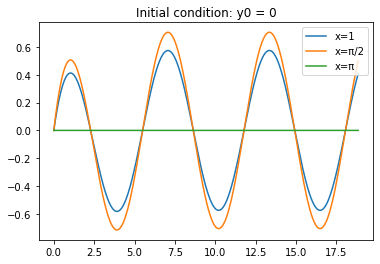

In [20]:
# Initial condition: y0 = 0
y0 = np.zeros((n,))
sol, t = fe(A,b,alpha,y0,t0,tf,h)

width = omega[1] - omega[0]
x_pi_2 = int(np.floor(n/width * np.pi/2.) - 1)
x_one = int(np.floor((n/width) - 1))
x_pi = int(np.floor((n/width *np.pi)) - 1)

plt.title("Initial condition: y0 = 0")
plt.plot(t, sol[:,x_one], label='x=1')
plt.plot(t, sol[:,x_pi_2], label='x=π/2')
plt.plot(t, sol[:,x_pi], label='x=π')
plt.legend()
plt.show()

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [21]:
def eigenvalue_LU(A,tol,nmax):
    B = A.copy()
    eigval_old = np.diag(B)
    err = tol+1.0
    it = 0
    
    while it < nmax and err > tol:
        L,U = LU(B)
        B = U@L
        eigval_new = np.diag(B)  
        err = np.linalg.norm(eigval_new - eigval_old,2)
        it += 1
        eigval_old = eigval_new
        
    return eigval_new

def eigenvector_LU(A,eigval,tol,nmax,nmax_ipm):
    eigvec = np.zeros_like(A)
    eigval_new = np.zeros_like(eigval)
    q = np.random.rand(A.shape[0])

    for i in range(len(eigval)):
        eigval_val, eigvec_val = IPM(A,q,eigval[i]+tol,tol,nmax_ipm)
        eigval_new[i] = eigval_val
        eigvec[:,i] = eigvec_val
         
    return eigval_new, eigvec

nmax = 2300
nmax_ipm = 13000
tol = 1e-7
eigenvalues = eigenvalue_LU(A,tol,nmax)
eigvals_new, eigenvectors = eigenvector_LU(A,eigenvalues,tol,nmax,nmax_ipm)

In [22]:
# Compare with Numpy
eval_np, evec_np = np.linalg.eig(A)
print("Mean Eigenvalue Error =", abs(np.mean(eval_np-eigenvalues)))

evec_err = np.zeros_like(eval_np)
for i in range(len(eval_np)):
    evec_err[i] = np.linalg.norm((eigenvectors[:,i] - evec_np[:,i]), 2)

print("Mean Eigenvector Norm Error =", abs(np.mean(evec_err)))

Mean Eigenvalue Error = 1.5101853101384678e-12
Mean Eigenvector Norm Error = 1.414213597640233


Compute the inverse of the matrix A exploiting the derived LU factorization

In [23]:
def inverse_matrix_LU(A):
    L,U = LU(A)
    N = len(A)
    A_inv = np.zeros_like(A)
    I = np.identity(A.shape[0])
    
    for i in range(N):
        q = L_solve(L,I[:,i])
        A_inv_i = U_solve(U,q)
        A_inv[:,i] = A_inv_i
    
    return A_inv

# Compare inverse to that computed by Numpy
A_inv_LU = inverse_matrix_LU(A)
A_inv_numpy = np.linalg.inv(A)
print("Maximum error in comparison to numpy:", max(np.abs(A_inv_LU - A_inv_numpy).max(axis=0)))

Maximum error in comparison to numpy: 1.2836953722228372e-15


Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [24]:
# Newton's Method function
def newton(f,f_prime,x0,eps,n_max):
    assert np.abs(f_prime(x0)) > 1e-16
    err = np.abs(f(x0))
    errors = [err]
    it = 0
    x = x0
    
    while (err > eps and it < n_max):
        qk = f_prime(x)
        if np.abs(qk) < 1e-12:
            raise RuntimeError("f_prime(x) is close to zero")
        
        x_new = x - f(x)/qk 
        err = np.abs(f(x_new))
        
        x = x_new
        errors.append(err)
        it += 1
            
        #plt.semilogy(errors)

    return x, errors

In [25]:
# Backward Euler Method Function
def be(y0,t0,tf,h):
    timesteps = np.arange(t0, tf+1e-10, h)
    t = timesteps
    sol = np.zeros_like(timesteps)
    sol[0] = y0
    eps = 1e-5
    n_max = 1000
    
    for i in range(1, len(sol)):
        f = lambda y: t[i]*h*y**2 + y - sol[i-1]
        df = lambda y: 2*t[i]*h*y + 1
        sol[i],_ = newton(f, df, sol[i-1], eps, n_max)

    return sol, timesteps

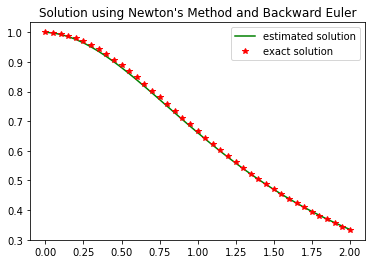

In [26]:
# Plot solution of Cauchy Problem

t0 = 0.0
tf = 2.0
y0 = 1.0

y,t = be(y0, t0, tf, 0.05)
y_ex = 2.0/(t*t + 2.0)

plt.title("Solution using Newton's Method and Backward Euler")
_ = plt.plot(t, y, 'g', label='estimated solution')
_ = plt.plot(t, y_ex, 'r*', label='exact solution')
plt.legend()